In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler,StandardScaler,Normalizer,RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import accuracy_score

import keras
import sklearn
from sklearn.utils import class_weight
import tensorflow.compat.v1 as tf
from tensorflow.keras.utils import to_categorical
from keras.models import Model
from keras.models import Input
from keras.layers import Dense,LSTM,Dropout,Flatten,Conv1D,MaxPool1D,AlphaDropout
from keras.layers import Permute,Reshape,RepeatVector,Multiply,Lambda,merge,BatchNormalization
from tensorflow.keras.layers import Attention
from keras import backend as K
from keras import regularizers
from keras.initializers import he_normal,lecun_normal,RandomNormal,glorot_normal,glorot_uniform
import keras.applications.resnet

from keras.layers import Embedding
from keras.layers import concatenate
from keras.layers import GaussianNoise,GaussianDropout
#时序交叉验证
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
#from sklearn.utils import shuffle
import time
import os
import matplotlib.pyplot as plt
import re


Using TensorFlow backend.


In [37]:
#####参数
global time_step,n_pred
time_step =40# 用100步预测未来-----time_steps
n_pred = 1  # 预测未来1步

#n_features = 9# 特征数
#对部分特征进行one_hot编码
#特征数从官方信息以及预处理文件中得到

#n_stu_features=1*3+1*8+1
global n_weather,n_address,cols
n_weather=7#
weather_list=['无','多云', '晴', '霾', '雨夹雪', '阴', '小雨']
n_address=10
cols=0

###网络参数
#embedding
static_emb_size=100

#lstm
lstm1_cell =128
lstm2_cell =128
lstm2_cell = 64

#action_statistic--hidden
#cnn
cnn_filter=128
kernel_sizes=1
#hidden
static_hidden1_cell=128
static_hidden2_cell=64
#
#特征融合--dense
hidden1_cell=128#和lstm_cell一样，要拼接
hidden2_cell=128

#attn
SINGLE_ATTENTION_VECTOR=False
#out
n_output_reg_cell = 1  # 回归
n_output_clas_cell = n_address # 分类(onehot),使用onehot编码分类树为编码长度

#training
epochs = 25#30
batch_size =8
#lr=0.001

In [3]:
#提前终止
from keras.callbacks import EarlyStopping
early_stopping=EarlyStopping(monitor='val_out_clas_accuracy',patience=6,mode='max')

#loss出现nan停止训练
from keras.callbacks import TerminateOnNaN
nan_stoping=TerminateOnNaN()

In [4]:
# Define our custom loss function
#regression
def huber(y_true, y_pred, delta=1):
    #return tf.reduce_mean(tf.square(true-pred)) with tf.Session() as sess:
    loss = tf.where(tf.abs(y_true-y_pred) < delta , 0.5*((y_true-y_pred)**2), delta*tf.abs(y_true - y_pred) - 0.5*(delta**2))
    #reduce_sum()中就是按照求和的方式对矩阵降维
    #reduce_mean()就是按照某个维度求平均值
    # K.sum(loss)
    return tf.reduce_sum(loss)
#classifoication
def focal_loss_softmax(y_true, y_pred,gamma=2.0,epsilon=1e-6):
    #多分类中alpha没用
    #alpha =0.25
    y_true=tf.convert_to_tensor(y_true,tf.float32)
    y_pred=tf.convert_to_tensor(y_pred,tf.float32)
    
    model_out=tf.add(y_pred,epsilon)
    ce=tf.multiply(y_true,-tf.log(model_out))
    weight=tf.multiply(y_true,tf.pow(tf.subtract(1.,model_out),gamma))
    fl=tf.multiply(1.,tf.multiply(weight,ce))
    reduce_fl=tf.reduce_max(fl,axis=1)
    return tf.reduce_mean(reduce_fl)
    
def focal_loss(y_true, y_pred,gamma=2.0,epsilon=1e-8):
   
    alpha =tf.constant([[0.15],[0.35],[0.45],[0.05],[0.2]],dtype=tf.float32)
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1+epsilon))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0+epsilon))

In [48]:
#define optimizer
#前5个epoch学习率保持不变，5个之后学习率按照指数进行衰减
def lr_decay(epoch):
    lr=0.005
    if epoch < 3:
        return lr
    elif epoch<10:
        return lr/10
    elif epoch<15: 
        return lr/100
    elif epoch<20: 
        return lr/500
    else:
        return lr/5000
        #return lr*tf.math.exp(0.1*(epochs-epoch))

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay)

In [49]:
#存储最佳权重
from keras.callbacks import ModelCheckpoint
checkpoint_filepath='best_weight_model-step40.hdf5'
print(checkpoint_filepath)
weight_callback = ModelCheckpoint( #创建回调
    filepath=checkpoint_filepath, #告诉回调要存储权重的filepath在哪
    save_weights_only=True, #只保留权重(更有效)，而不是整个模型
    monitor='val_out_clas_accuracy', #度量
    mode='max', #找出使度量最大化的模型权重
    save_best_only=True #只保留最佳模型的权重(更有效)，而不是所有的权重
)

best_weight_model-step40.hdf5


In [44]:
date='2021/11/28 19:03:00'
hour = re.search('(\d+)/(\d+)/(\d+) (\d+):(\d+):(\d+)',date).group(4)
print(hour)

19


In [8]:
#对时间步的attention
def attention_time_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)#行列互换，求矩阵inputs的转置
    a = Reshape((input_dim, time_step))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(time_step, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_time_vec')(a)
    time_attention_out= Multiply()([inputs, a_probs])                                        
    return time_attention_out

In [9]:
#数据增强
def wgn(x, snr):
    #print(x)
    
    batch_size, len_x = x.shape
    Ps = np.sum(np.power(x, 2)) / len_x
    Pn = Ps / (np.power(10, snr / 10))
    noise = np.random.randn(len_x) * np.sqrt(Pn)
    #print(x + noise)
    return x + noise

In [10]:
def data_process(data):
    cols=list(data)
    #weather属性处理 
    data.weather[(data.weather=='999')|(data.weather=='0')]="无"
    #['多云', '晴', '霾', '无', '雨夹雪', '阴', '小雨'] 
    for i, row in data.iterrows():
        hour = float(re.search('(\d+)-(\d+)-(\d+) (\d+):(\d+):(\d+)',row.start_time).group(4))
        data.loc[i,'start_time'] = hour
        #data.loc[i,'floor'] = int(data.loc[i,'floor'])
        data.loc[i,'weather']=weather_list.index(row.weather)
        data.loc[i,'19_sensor_value1']=(data.loc[i,'19_sensor_value1'])/10000
        #ata.loc[i,'5_sensor_value1.1']=abs(data.loc[i,'5_sensor_value1.1'])
        #ata.loc[i,'3_sensor_value2']=abs(data.loc[i,'3_sensor_value2'])
        #ata.loc[i,'3_sensor_value3']=abs(data.loc[i,'3_sensor_value3'])
        if row.time_span>100:
            data.loc[i,'time_span']=100
        if row.time_span<1:
            data.loc[i,'time_span']=1  
        data.loc[i,'time_span']=(data.loc[i,'time_span'])/60
        if row.time_interval>120:
            data.loc[i,'time_interval']=120
        data.loc[i,'time_interval']=(data.loc[i,'time_interval'])/60
            
    data.loc[:,'address':'weather'].astype('float64')
    data.loc[:,'5_sensor_value1.1':].astype('float64')
    
    #数据集划分
    all_scale=data.values.shape[0]
    train_scale = int(all_scale * 0.4)
    test_scale = all_scale - train_scale
    
    #数据增强
    train_data=pd.DataFrame()
    noise_data=pd.DataFrame()
    test_data=data.loc[:,'address':]
    
    address_data=data.loc[train_scale:,'address':'start_time']
    weather_data=data.loc[train_scale:,'weather']
    data1=data.loc[train_scale:,'time_span':'floor']
    data2=data.loc[train_scale:,'5_sensor_value1.1':]

    snr = 20
    for i in range(30):
        data1_noise = wgn(data1, snr)
        data2_noise = wgn(data2, snr)

        noise_data = pd.concat([address_data, data1_noise], axis=1)
        noise_data = pd.concat([noise_data, weather_data], axis=1)
        noise_data = pd.concat([noise_data, data2_noise], axis=1)
        if i==0:
            train_data=noise_data
        else:
            train_data=pd.concat([train_data, noise_data], axis=0)
    
    train_data_value = train_data.values
    #data_value = data.values
    onehot_weather_encoder=to_categorical(train_data_value[:,cols.index('weather')], n_weather)
    onehot_address_encoder=to_categorical(train_data_value[:,cols.index('address')], n_address)
    
    train_value=np.concatenate((onehot_address_encoder,train_data_value[:,cols.index('address')+1:cols.index('weather')]), axis=1)
    train_value=np.concatenate((train_value,onehot_weather_encoder), axis=1)
    train_value=np.concatenate((train_value,train_data_value[:,cols.index('weather')+1:]), axis=1)
    
    test_data_value = test_data.values
    #data_value = data.values
    onehot_weather_encoder=to_categorical(test_data_value[:,cols.index('weather')], n_weather)
    onehot_address_encoder=to_categorical(test_data_value[:,cols.index('address')], n_address)
    
    test_value=np.concatenate((onehot_address_encoder,test_data_value[:,cols.index('address')+1:cols.index('weather')]), axis=1)
    test_value=np.concatenate((test_value,onehot_weather_encoder), axis=1)
    test_value=np.concatenate((test_value,test_data_value[:,cols.index('weather')+1:]), axis=1)
    return cols,train_value,test_value


In [11]:
# 构造nstep->n_pred的监督型数据,n_steo组数据预测n_pred组
# 隐式添加时序信息
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_dcol = 1 if type(data) is list else data.shape[1]  # data列数
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # 输入序列（t-n,...,t-1）
    # 将三组输入数据依次向下移动n,n-1,..,1行，将数据加入cols列表
    # var1----var7表示action(one-hot)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_dcol)]
    # 预测序列（t，t+1,t+n）
    # 将一组数据加入cols列表
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_dcol)]
        else:
            names += [('var%d(t+i)' % (j + 1)) for j in range(n_dcol)]
    # 将数据列表（cols）中现有的time_step+n_pred块（df-n_in,df-n_in+1,...df-1,df,..,df+n_pred+1）按列合并
    agg = pd.concat(cols, axis=1)
    # 为合并后的数据添加列名
    agg.columns = names
    
    #移位后产生的NaN值补0
    #agg.fillna(0,inplace=True)
    print(data.shape)
    print('agg:',agg.shape)
    # 删除NaN值
    if dropnan:
        agg.dropna(inplace=True)  # dropna()
    agg = agg.reset_index(drop=True)  # 删除原始索引，否则会生成一列index
    
    return agg 

In [12]:
print(int('1'))

1


In [13]:
read_dir = 'F:\\DeepLearning\\DataSet\\mobile_data\\SnnuLog\\process\\process\\data'
user_list = os.listdir(read_dir)
user_train_data=pd.DataFrame()
user_test_data=pd.DataFrame()
user_i = 1
for user in user_list:
    # 加载数据
    #, usecols=['name','weather']
    #dataset = pd.read_csv(os.path.join(read_dir, user),sep=',', usecols=['address','start_time','time_span','time_interval','floor','weather','5_sensor_value1.1','5_sensor_value2.1','5_sensor_value3.1','19_sensor_value1'],encoding='gbk',engine='python')
    dataset = pd.read_csv(os.path.join(read_dir, user),sep=',', usecols=['address','start_time','time_span','time_interval','floor','weather','5_sensor_value1.1','5_sensor_value2.1','5_sensor_value3.1','19_sensor_value1'],encoding='gbk',engine='python')
    
    #dataset = pd.read_csv(os.path.join(read_dir, user))
    dataset.dropna(axis=0,how='any',inplace = True)
    #sub(模式串，（去替换模式串的字符串），主串)
    en_id=re.sub('.csv','',user) 
    if len(dataset) <=time_step*0.5:
        continue
    #数据处理
    print(user)
    cols,train_value,test_value= data_process(dataset)
    train_value  = train_value.astype('float32')
    test_value  = test_value.astype('float32')
    
    # 构造监督型时序数据time_step---->n_pred
    train_data_reframed = series_to_supervised(train_value, time_step, n_pred)
    test_data_reframed = series_to_supervised(test_value, time_step, n_pred)
    #list1=data['weather'].drop_duplicates().values.tolist()
    #print(user,":  ",list1,"   ",len(list1))
    
    if user_i == 1:
        user_train_data= train_data_reframed 
        user_test_data= test_data_reframed 
    else:
        user_train_data = pd.concat((user_train_data, train_data_reframed ), axis=0)
        user_test_data = pd.concat((user_test_data, test_data_reframed ), axis=0)
    #if len(dataset) >= time_step:
        #user_i += 1
    user_i += 1
user_train_data = user_train_data.reset_index(drop=True)  
user_test_data = user_test_data.reset_index(drop=True)  
#list1=all_user_data['weather'].drop_duplicates().values.tolist()
#print(list1,"   ",len(list1))

Tom1.csv


D:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


(1140, 25)
agg: (1140, 1025)
(63, 25)
agg: (63, 1025)
Tom10.csv
(1410, 25)
agg: (1410, 1025)
(77, 25)
agg: (77, 1025)
Tom11.csv
(420, 25)
agg: (420, 1025)
(22, 25)
agg: (22, 1025)
Tom12.csv
(450, 25)
agg: (450, 1025)
(24, 25)
agg: (24, 1025)
Tom16.csv
(1230, 25)
agg: (1230, 1025)
(67, 25)
agg: (67, 1025)
Tom17.csv
(1140, 25)
agg: (1140, 1025)
(62, 25)
agg: (62, 1025)
Tom18.csv
(990, 25)
agg: (990, 1025)
(55, 25)
agg: (55, 1025)
Tom21.csv
(810, 25)
agg: (810, 1025)
(45, 25)
agg: (45, 1025)
Tom22.csv
(2250, 25)
agg: (2250, 1025)
(125, 25)
agg: (125, 1025)
Tom23.csv
(1050, 25)
agg: (1050, 1025)
(58, 25)
agg: (58, 1025)
Tom25.csv
(870, 25)
agg: (870, 1025)
(48, 25)
agg: (48, 1025)
Tom27.csv
(690, 25)
agg: (690, 1025)
(38, 25)
agg: (38, 1025)
Tom28.csv
(810, 25)
agg: (810, 1025)
(44, 25)
agg: (44, 1025)
Tom3.csv
(1500, 25)
agg: (1500, 1025)
(82, 25)
agg: (82, 1025)
Tom33.csv
(1710, 25)
agg: (1710, 1025)
(95, 25)
agg: (95, 1025)
Tom38.csv
(450, 25)
agg: (450, 1025)
(24, 25)
agg: (24, 1025)
T

In [14]:
user_train_data

,var1(t-40),var2(t-40),var3(t-40),var4(t-40),var5(t-40),var6(t-40),var7(t-40),var8(t-40),var9(t-40),var10(t-40),...,var16(t),var17(t),var18(t),var19(t),var20(t),var21(t),var22(t),var23(t),var24(t),var25(t)
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.477276,-12.267025,-1.519993,0.215831
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,-2.052294,0.015085,10.683155,0.243531
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,-4.167462,-0.114550,10.251273,0.284531
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.183234,-2.936719,11.221202,1.106531
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,-1.415762,-1.542515,11.101379,0.248931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21935,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.575049,0.858089,10.764350,-0.162179
21936,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,4.648268,6.789383,-3.555351,0.024721
21937,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,-2.199295,-1.283285,10.602699,0.024721
21938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.146625,0.151430,10.831491,0.120221


In [15]:
user_test_data

,var1(t-40),var2(t-40),var3(t-40),var4(t-40),var5(t-40),var6(t-40),var7(t-40),var8(t-40),var9(t-40),var10(t-40),...,var16(t),var17(t),var18(t),var19(t),var20(t),var21(t),var22(t),var23(t),var24(t),var25(t)
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-6.100903,-7.257038,-2.506959,1.0664
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.021410,0.133570,9.805717,0.2064
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-9.744873,-1.098958,0.011057,1.0800
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.015656,0.126635,9.805820,0.2064
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.002500,-9.658417,-1.371275,0.3826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,3.613100,-9.116199,0.091300,8.5954
406,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-5.888900,-7.839200,-0.191000,1.1677
407,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,-2.011534,-0.888462,9.556921,0.2907
408,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.334386,0.546253,9.785713,0.3862


In [16]:
#数据转换
train_values = user_train_data.values
test_values = user_test_data.values
print(train_values.shape,test_values.shape)

(21940, 1025) (410, 1025)


In [17]:

features=train_values.shape[1]-(len(cols)-2+n_weather+n_address)


# 分割训练集、验证集和测试集6:2:2
# x, y = sklearn.utils.shuffle(X, Y)
#all_value_shuffle= sklearn.utils.shuffle(all_value,random_state=1) 
#shuffle
#value_train=all_value_shuffle[:train_scale,:]
#value_val=all_value_shuffle[train_scale:train_scale + val_scale,:]
#value_test=all_value_shuffle[train_scale + val_scale:,:]


scaler=MinMaxScaler(feature_range=(0,1)).fit(train_values)
scaled_value_train=scaler.transform(train_values)
scaled_value_test=scaler.transform(test_values)

In [18]:
print(cols)

['address', 'start_time', 'time_span', 'time_interval', 'floor', 'weather', '5_sensor_value1.1', '5_sensor_value2.1', '5_sensor_value3.1', '19_sensor_value1']


In [19]:
print(features)

1000


In [20]:
scaled_trainX, scaled_train_Yclass,scaled_train_Ytp,scaled_train_Yti = scaled_value_train[:, :features],scaled_value_train[:,features:features+n_address],scaled_value_train[:,features+n_address+1:features+n_address+2],scaled_value_train[:,features+n_address+2:features+n_address+3]
scaled_testX, scaled_test_Yclass,scaled_test_Ytp,scaled_test_Yti = scaled_value_test[:, :features],scaled_value_test[:,features:features+n_address],scaled_value_test[:,features+n_address+1:features+n_address+2],scaled_value_test[:,features+n_address+2:features+n_address+3]

#
scaled_trainX=scaled_trainX.reshape((scaled_trainX.shape[0], time_step,(len(cols)-2+n_weather+n_address)))
scaled_testX=scaled_testX.reshape((scaled_testX.shape[0], time_step,(len(cols)-2+n_weather+n_address)))
print(scaled_trainX.shape)

(21940, 40, 25)


In [21]:
print(scaled_testX.shape)

(410, 40, 25)


In [45]:
#class_weight(类别不均衡)
y_integers = np.argmax(scaled_train_Yclass, axis=1)
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[1 2 3 4 5 6 7 8 9], y=[5 7 8 ... 5 1 5] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [50]:
#building model
#Lstm-CNN
#设计网络
# Input
user_input = Input(shape=(scaled_trainX.shape[1], scaled_trainX.shape[2]),name='input')
lstm1 = LSTM(64, activation=tf.nn.relu,
                    kernel_initializer=he_normal(seed=1),
                    #kernel_regularizer=regularizers.l1_l2(l1=0.05,l2=0.1),
                    use_bias=True,
                    return_sequences=True)(user_input)
lstm1=BatchNormalization()(lstm1)
#lstm1=GaussianDropout(rate=0.4)(lstm1)
lstm1=Dropout(rate=0.1)(lstm1)
lstm2 = LSTM(64, activation=tf.nn.relu,
                    kernel_initializer=he_normal(seed=1),
                    #kernel_regularizer=regularizers.l1_l2(l1=0.05,l2=0.1),
                    use_bias=True,
                    return_sequences=True)(lstm1)
#lstm2=BatchNormalization()(lstm2)
#lstm1=GaussianDropout(rate=0.4)(lstm1)
lstm2=Dropout(rate=0.4)(lstm2)
#lstm_gassian_noise=GaussianNoise(stddev=0.2)(lstm1)
attention_time=attention_time_block(lstm2)


#cnn=BatchNormalization()(cnn)

#combinedX=concatenate([lstm2,attention_time])

lstm3 = LSTM(64, activation='relu', 
             kernel_initializer=he_normal(seed=1),
             return_sequences=True,
            #kernel_regularizer=regularizers.l1_l2(l1=0.1,l2=0.1)，
             use_bias=True)(attention_time)
lstm3=Dropout(rate=0.1)(lstm3)
cnn=Conv1D(filters=32,
           kernel_size=1,
           activation=tf.nn.relu,
           use_bias=True)(lstm3)
cnn=Dropout(rate=0.4)(cnn)

lstm4 = LSTM(64, activation='relu', 
             kernel_initializer=he_normal(seed=1),
             return_sequences=True,
            #kernel_regularizer=regularizers.l1_l2(l1=0.1,l2=0.1)，
             use_bias=True)(cnn)
lstm4=Dropout(rate=0.2)(lstm4)
lstm = LSTM(64, activation='relu', 
             kernel_initializer=he_normal(seed=1),
             return_sequences=True,
            #kernel_regularizer=regularizers.l1_l2(l1=0.1,l2=0.1)，
             use_bias=True)(lstm4)
lstm=Dropout(rate=0.3)(lstm)
lstmG=GaussianDropout(rate=0.2)(lstm)


combined_classX=concatenate([attention_time,lstmG])

flatten=Flatten()(combined_classX)



#hidden--class
class_hidden1=Dense(64,activation=tf.nn.leaky_relu,
                            kernel_initializer=glorot_normal(seed=3),
                            bias_initializer='random_uniform',
                            #kernel_regularizer=regularizers.l1_l2(l1=0.01,l2=0.03),
                            use_bias=True)(flatten)
class_hidden1=Dropout(rate=0.2)(class_hidden1)
class_hidden2=Dense(32,activation=tf.nn.tanh, 
                            kernel_initializer=he_normal(seed=3),
                            #kernel_regularizer=regularizers.l1_l2(l1=0.05,l2=0.1),
                            use_bias=True)(class_hidden1)
class_hidden2=Dropout(rate=0.1)(class_hidden2)
#class_hidden3=Dense(32,activation=tf.nn.leaky_relu, 
#                            kernel_initializer=he_normal(seed=3),
                            #kernel_regularizer=regularizers.l1_l2(l1=0.05,l2=0.1),
#                            use_bias=True)(class_hidden2)
#class_hidden3=Dropout(rate=0.1)(class_hidden3)
#hidden-reg

reg1_hidden1=Dense(64,activation=tf.nn.leaky_relu, 
                            kernel_initializer=he_normal(seed=3), 
                            #kernel_regularizer=regularizers.l1_l2(l1=0.01,l2=0.3),
                            use_bias=True)(flatten)
reg1_hidden1=Dropout(rate=0.2)(reg1_hidden1)
reg1_hidden2=Dense(32,activation=tf.nn.leaky_relu, 
                            kernel_initializer=he_normal(seed=3), 
                            #kernel_regularizer=regularizers.l1_l2(l1=0.01,l2=0.01),
                            use_bias=True)(reg1_hidden1)
reg1_hidden2=Dropout(rate=0.1)(reg1_hidden2)
#reg1_hidden3=Dense(32,activation=tf.nn.leaky_relu, 
#                            kernel_initializer=he_normal(seed=3), 
#                            kernel_regularizer=regularizers.l1_l2(l1=0.01,l2=0.01),
#                            use_bias=True)(reg1_hidden2)
#reg1_hidden3=Dropout(rate=0.1)(reg1_hidden3)
reg2_hidden1=Dense(64,activation=tf.nn.leaky_relu, 
                            kernel_initializer=he_normal(seed=3), 
                            #kernel_regularizer=regularizers.l1_l2(l1=0.01,l2=0.3),
                            use_bias=True)(flatten)
reg2_hidden1=Dropout(rate=0.2)(reg2_hidden1)
reg2_hidden2=Dense(32,activation=tf.nn.leaky_relu, 
                            kernel_initializer=he_normal(seed=3), 
                            #kernel_regularizer=regularizers.l1_l2(l1=0.01,l2=0.01),
                            use_bias=True)(reg2_hidden1)
reg2_hidden2=Dropout(rate=0.1)(reg2_hidden2)

#dense
out_clas = Dense(n_address, activation='softmax', name='out_clas')(class_hidden2)
out_reg_tp = Dense(1,activation=tf.nn.sigmoid, name='out_reg_tp')(reg1_hidden2)
out_reg_ti = Dense(1,activation=tf.nn.sigmoid, name='out_reg_ti')(reg2_hidden2)

# define model
model = Model(inputs=[user_input],
              outputs=[out_clas,out_reg_tp,out_reg_ti])

In [61]:
# 编译器
# [tf.keras.metrics.AUC(name='auc')]
#categorical_crossentropy,focal_loss_softmax

model.compile(loss={'out_clas':focal_loss_softmax,'out_reg_tp':huber,'out_reg_ti':huber },  optimizer='adam',
              metrics={ 'out_clas': 'accuracy','out_reg_tp':'mse','out_reg_ti':'mse'})
# 训练拟合网络
history = model.fit({'input':scaled_trainX},
                    { 'out_clas':scaled_train_Yclass,'out_reg_tp':scaled_train_Ytp,'out_reg_ti':scaled_train_Yti},
                    epochs=40,
                    batch_size=8,
                    class_weight=d_class_weights,
                    validation_data=([scaled_testX], [scaled_test_Yclass,scaled_test_Ytp,scaled_test_Yti]),
                    shuffle=True,
                    #early_stopping,,shuffle=True
                    verbose=1,callbacks=[lr_callback,early_stopping,nan_stoping,weight_callback])
# 打印网络结构
model.summary()
#callbacks=[early_stopping]

Train on 21940 samples, validate on 410 samples
Epoch 1/40
21940/21940 [==============================] - 209s 10ms/step - loss: 0.1783 - out_clas_loss: 0.0953 - out_reg_tp_loss: 0.0268 - out_reg_ti_loss: 0.0562 - out_clas_accuracy: 0.9333 - out_reg_tp_mse: 0.0067 - out_reg_ti_mse: 0.0141 - val_loss: 0.5138 - val_out_clas_loss: 0.4139 - val_out_reg_tp_loss: 0.0291 - val_out_reg_ti_loss: 0.0638 - val_out_clas_accuracy: 0.7951 - val_out_reg_tp_mse: 0.0074 - val_out_reg_ti_mse: 0.0162
Epoch 2/40
21940/21940 [==============================] - 242s 11ms/step - loss: 0.1418 - out_clas_loss: 0.0668 - out_reg_tp_loss: 0.0245 - out_reg_ti_loss: 0.0505 - out_clas_accuracy: 0.9519 - out_reg_tp_mse: 0.0061 - out_reg_ti_mse: 0.0126 - val_loss: 0.5306 - val_out_clas_loss: 0.4279 - val_out_reg_tp_loss: 0.0381 - val_out_reg_ti_loss: 0.0616 - val_out_clas_accuracy: 0.8049 - val_out_reg_tp_mse: 0.0097 - val_out_reg_ti_mse: 0.0156
Epoch 3/40
21940/21940 [==============================] - 234s 11ms/step -

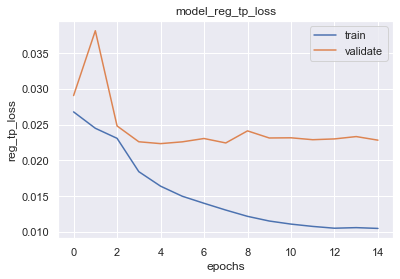

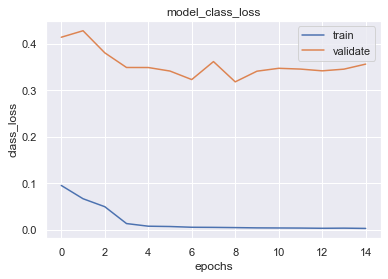

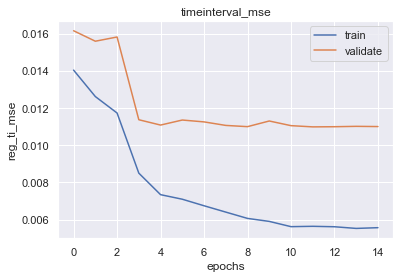

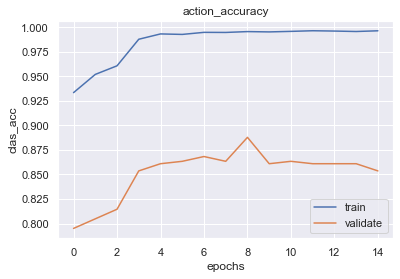

In [62]:
# 绘图
# plot history
plt.plot(history.history['out_reg_tp_loss'], label='train')
plt.plot(history.history['val_out_reg_tp_loss'], label='validate')
plt.xlabel('epochs')
plt.ylabel('reg_tp_loss')
plt.legend()
plt.title('model_reg_tp_loss')
plt.show()

#
# plot history
plt.plot(history.history['out_clas_loss'], label='train')
plt.plot(history.history['val_out_clas_loss'], label='validate')
plt.xlabel('epochs')
plt.ylabel('class_loss')
plt.legend()
plt.title('model_class_loss')
plt.show()

# plot history
plt.plot(history.history['out_reg_ti_mse'], label='train')
plt.plot(history.history['val_out_reg_ti_mse'], label='validate')
plt.xlabel('epochs')
plt.ylabel('reg_ti_mse')
plt.legend()
plt.title('timeinterval_mse')
plt.show()
#plt.close

# plt.plot(history.history['sparse_categorical_accuracy'],label='train')
# plt.plot(history.history['val_sparse_categorical_accuracy'],label='validate')
plt.plot(history.history['out_clas_accuracy'], label='train')
plt.plot(history.history['val_out_clas_accuracy'], label='validate')
plt.xlabel('epochs')
plt.ylabel('clas_acc')
plt.title('action_accuracy')
plt.legend()
plt.show()

In [63]:
#将最佳权重装入模型中
model.load_weights(checkpoint_filepath) 
#clas_train_pred,reg_tp_train_pred,reg_ti_train_pred=model.predict({'enroll_input':scaled_trainX})
# 预测
clas_test_pred,reg_tp_test_pred,reg_ti_test_pred= model.predict({'input':scaled_testX})


In [64]:
# 逆缩放维度要求：n行*features列
#拼接之前需要知道开始怎么对数据进行拼接的
# 现进行数据拼接，再对预测数据进行逆缩放
# test_X=test_X.reshape(test_X.shape[0],n_step*n_features)

# 现进行数据拼接，再对真实数据进行逆缩放
inv_Ytrue_test = scaler.inverse_transform(scaled_value_test)
inv_Ytrue_train=scaler.inverse_transform(scaled_value_train)

#预测值缩放
reg_tp_test_pred = reg_tp_test_pred.reshape(len(reg_tp_test_pred), 1)
reg_ti_test_pred = reg_ti_test_pred.reshape(len(reg_ti_test_pred), 1)
test_st=scaled_value_test[:,features+n_address]
test_st = test_st.reshape(len(test_st), 1)

test_pred=np.concatenate((scaled_value_test[:,:features],clas_test_pred),axis=1)
test_pred=np.concatenate((test_pred,test_st),axis=1)
test_pred=np.concatenate((test_pred,reg_tp_test_pred),axis=1)
test_pred=np.concatenate((test_pred,reg_ti_test_pred),axis=1)
test_pred=np.concatenate((test_pred,scaled_value_test[:,features+n_address+3:]),axis=1)
inv_test_pred = scaler.inverse_transform(test_pred)

In [65]:
#取整
#for i in range(0,len(inv_test_pred)):
    #inv_test_pred[i,(enroll_features-n_timespan)]=int(inv_test_pred[i,(enroll_features-n_timespan)])

In [66]:
# 计算回归模型RMSE误差值
#enroll_test_Y=np.power(2,enroll_test_Y)
#reg_yhat=np.power(2,reg_yhat)
print(inv_Ytrue_test[:,features+n_address+1].max())
print(inv_test_pred[:,features+n_address+1].max())

rmse = math.sqrt(mean_squared_error(abs(inv_Ytrue_test[:,(features+n_address+1)]),abs(inv_test_pred[:,(features+n_address+1)])))
print('Test timespan RMSE:%.3f' %rmse)
rmse = math.sqrt(mean_squared_error(abs(inv_Ytrue_test[:,(features+n_address+2)]),abs(inv_test_pred[:,(features+n_address+2)])))
print('Test timein RMSE:%.3f' %rmse)

1.6666666
1.7956583
Test timespan RMSE:0.228
Test timein RMSE:0.477


In [67]:
mae = mean_absolute_error(abs(inv_Ytrue_test[:,(features+n_address+1)]),abs(inv_test_pred[:,(features+n_address+1)]))
print('Test timespan mae:%.3f' %mae)
mae = mean_absolute_error(abs(inv_Ytrue_test[:,(features+n_address+2)]),abs(inv_test_pred[:,(features+n_address+2)]))
print('Test timeint mae:%.3f' %mae)

Test timespan mae:0.076
Test timeint mae:0.318


In [68]:
######全局
#全局准确率
class_pred = np.argmax(test_pred[:,features:features+n_address], axis=-1).astype('int')  # 返回最大数的索引
yclas = np.argmax(inv_Ytrue_test[:,features:features+n_address], axis=-1).astype('int')
acc = accuracy_score(yclas,class_pred)
print("acurracy:%.3f" % (acc*100),'%')



TypeError: 'numpy.float64' object is not callable

              precision    recall  f1-score   support

           1    0.87500   0.83051   0.85217        59
           2    0.57895   1.00000   0.73333        11
           3    0.90323   0.89362   0.89840        94
           4    0.88889   0.84211   0.86486        19
           5    0.94643   0.86885   0.90598        61
           6    0.76471   1.00000   0.86667        13
           7    0.91011   0.85263   0.88043        95
           8    0.81818   1.00000   0.90000        18
           9    0.97500   0.97500   0.97500        40

    accuracy                        0.88780       410
   macro avg    0.85117   0.91808   0.87521       410
weighted avg    0.89670   0.88780   0.88927       410



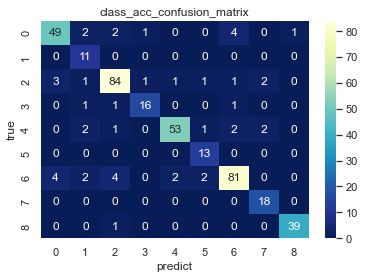

In [69]:
#计算混淆矩阵
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
#统计每个类别的预测准确率、召回率、F1-score
print(classification_report(class_pred,yclas,digits=5))
#计算混淆矩阵
confusion_mat=confusion_matrix(class_pred,yclas)
sns.set()
figure,ax=plt.subplots()
sns.heatmap(confusion_mat,cmap='YlGnBu_r',annot=True,ax=ax)
#标题
ax.set_title('class_acc_confusion_matrix')
#x轴为预测类别
ax.set_xlabel('predict')
#y为实际类别
ax.set_ylabel('true')
#在 plt.show() 之前调用 plt.savefig()
#plt.savefig('./mymodel/confusion_mat.png')
plt.show()

D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\metrics\_ranking.py:813: U

Precision_score: 0.8934456110318792


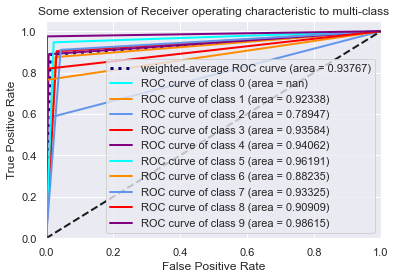

In [70]:
#roc
from sklearn import metrics
from sklearn.metrics import recall_score,accuracy_score
from sklearn.metrics import precision_score,f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from itertools import cycle

class_test_one_hot = label_binarize(yclas, classes=np.arange(n_address))
class_test_one_hot_hat=label_binarize(class_pred, classes=np.arange(n_address))
# weighted：不均衡数量的类来说，计算二分类metrics的平均
precision = precision_score(class_test_one_hot , class_test_one_hot_hat, average='weighted')
recall = recall_score(class_test_one_hot , class_test_one_hot_hat, average='weighted')
f1_score = f1_score(class_test_one_hot , class_test_one_hot_hat, average='weighted')
accuracy_score = accuracy_score(class_test_one_hot , class_test_one_hot_hat)
print("Precision_score:",precision)


# roc_curve:真正率（True Positive Rate , TPR）或灵敏度（sensitivity）
# 横坐标：假正率（False Positive Rate , FPR）
 
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_address):
    fpr[i], tpr[i], _ = roc_curve(class_test_one_hot[:, i], class_test_one_hot_hat[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute weight-average ROC curve and ROC area
fpr["weighted"], tpr["weighted"], _ = roc_curve(class_test_one_hot.ravel(), class_test_one_hot_hat.ravel())
roc_auc["weighted"] = auc(fpr["weighted"], tpr["weighted"])

# Plot all ROC curves
lw = 2
plt.figure()
plt.plot(fpr["weighted"], tpr["weighted"],
  label='weighted-average ROC curve (area = {0:0.5f})'
  ''.format(roc_auc["weighted"]),
  color='navy', linestyle=':', linewidth=3)
 
colors = cycle(['aqua', 'darkorange', 'cornflowerblue','red','purple'])
for i, color in zip(range(n_address), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.5f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
#plt.savefig("")
plt.show()